<a href="https://colab.research.google.com/github/nazmus007/transformers_test/blob/main/distilbert_semeval_run1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 !pip install -qq transformers

     |████████████████████████████████| 2.9 MB 5.1 MB/s 
     |████████████████████████████████| 895 kB 49.0 MB/s 
     |████████████████████████████████| 636 kB 31.5 MB/s 
     |████████████████████████████████| 56 kB 5.3 MB/s 
     |████████████████████████████████| 3.3 MB 46.0 MB/s 


In [ ]:
print(transformers.__version__)

NameError: ignored

In [2]:
!pip install emoji

     |████████████████████████████████| 168 kB 5.1 MB/s 
  Created wheel for emoji: filename=emoji-1.6.0-py3-none-any.whl size=168256 sha256=82b026207fbebd37e2fa86543cebc59bf913ba80513566ed23a29ee420661dc6
  Stored in directory: /root/.cache/pip/wheels/f7/d7/74/c720aaf345a042b0c2d74361873258c5e8649b7f11b2ccce49
Successfully built emoji


In [ ]:
torch.cuda.empty_cache()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install demoji

     |████████████████████████████████| 42 kB 1.5 MB/s 


In [ ]:
!nvidia-smi

Thu Sep 30 13:07:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import transformers

from transformers import DistilBertModel, DistilBertTokenizer, AdamW, get_linear_schedule_with_warmup, DistilBertForSequenceClassification

import torch
import re
import numpy as np
import pandas as pd

import seaborn as sns

from pylab import rcParams

import matplotlib.pyplot as plt

from matplotlib import rc

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, classification_report

from collections import defaultdict

from textwrap import wrap

from torch import nn, optim

from torch.utils.data import Dataset, DataLoader
import emoji

In [5]:
import torch.nn.functional as F

In [6]:
df = pd.read_csv("./drive/MyDrive/datasets/cleaned_semeval_wnotebook_5.csv")
df.head()

,Tweet index,Label,Tweet
0,1,1,sweet united nations video just in time for ch...
1,2,1,we are rumored to have talked to erv is agent ...
2,3,1,hey there nice to see you minnesotand winter w...
3,4,0,3 episodes left i am dying over here
4,5,1,i cannot breathe was chosen as the most notabl...


In [7]:
df = df.drop(['Tweet index'],axis=1)

In [8]:
df.dropna(subset = ["Tweet"], inplace=True)

In [9]:
import emoji
def extract_emojis(s):
    return ''.join((' '+c+' ') if c in emoji.UNICODE_EMOJI['en'] else c for c in s)

In [10]:
df['Tweet'] = df['Tweet'].apply(extract_emojis)

In [11]:
df.columns = df.columns.str.lstrip()

In [12]:
pd.options.display.max_colwidth = 130

In [13]:
df.iloc[1959:1967]

,Label,Tweet
1959,1,so glad they have found a way to make the gospel socially relevant to klingons
1960,0,oo ummmso like rt from our family to yours have a safe and happythanksgiving
1961,0,my death will likely be caused by at the wrong time
1962,0,everybody just keeps saying gronk and large contingent of patriots who else is there with rob
1963,1,dad and step mom bitching at each other now it is christmas 😊 🎄 😤 disgusted
1964,1,internet got me like 😩 stillalive
1965,1,the joy i have for overnight stakeouts
1967,1,gutted doyle has gone back to wwfc i do not think we saw what he is capable of cpfc


In [ ]:
emoji_1 = re.compile('[\\u203C-\\u3299\\U0001F000-\\U0001F644]')

In [ ]:
emoji_list= list(filter(emoji_1.match, df['Tweet text']))

In [ ]:
def extract_emojis(text):
    return ''.join(c for c in text if c in emoji.UNICODE_EMOJI)

In [ ]:
df['emoji_apply'] = df['Tweet text'].apply(extract_emojis)

In [ ]:
df.head(25)

,Label,Tweet text,emoji_apply
0,1,sweet united nations video just in time for ch...,
1,1,we are rumored to have talked to erv is agent...,
2,1,hey there nice to see you minnesotand winter w...,
3,0,3 episodes left i am dying over here,
4,1,i cannot breathe was chosen as the most notabl...,
5,0,you are never too old for footie pajamas,
6,1,nothing makes me happier then getting on the h...,
7,0,430 an opening my first beer now gonna be a lo...,
8,0,do you think you would support a guy who knoc...,
9,0,you are not allowed to open that until christ...,


In [ ]:
emoji_list= list(filter(emoji_1.match, df['Tweet text']))

In [ ]:
print(emoji_list)

['👊 fistbump positive focus starve distractions werk motivation createpath uplift success ', '😒 half of the testing group was very helpful today ', '🙀😱🙀😱🙀😱 popcorn 😂🎅😂🎅😂🔫🔫 bringing this at movie tuesday night  ', '🇫🇴🇱🇱🇴🇼 thistsu website now worth 15 millionyou get paid for posting ', '😂😂 i will let you and bb know how i get on xx', '🎉it is monday 🎉 ']


In [ ]:
emo_found= ' '.join(emoji for emoji in emoji_list)

In [ ]:
from emoji import UNICODE_EMOJI

def get_emoji_set(text):
    return {letter for letter in text if letter in UNICODE_EMOJI['en'] }

In [ ]:
c = get_emoji_set(emo_found)

In [ ]:
print(c)

{'🙀', '🎉', '🎅', '👊', '😂', '😱', '😒', '🔫'}


In [18]:
!pip install demoji

     |████████████████████████████████| 42 kB 780 kB/s 


In [21]:
import demoji
def demoji_text(text):
  d= demoji.findall(text)
  return d
  

In [22]:
df['emoji_list'] = df['Tweet'].apply(demoji_text)

In [23]:
df.head()

,Label,Tweet,emoji_list
0,1,sweet united nations video just in time for christmas imagine noreligion,{}
1,1,we are rumored to have talked to erv is agent and the angels asked about ed escobar that is hardly nothing,{}
2,1,hey there nice to see you minnesotand winter weather,{}
3,0,3 episodes left i am dying over here,{}
4,1,i cannot breathe was chosen as the most notable quote of the year in an annual list released by a yale university librarian,{}


In [24]:
f= list(filter(None, df['emoji_list']))

In [25]:
print(f)

[{'😡': 'pouting face'}, {'😬': 'grimacing face'}, {'❤': 'red heart'}, {'😅': 'grinning face with sweat'}, {'😁': 'beaming face with smiling eyes'}, {'😐': 'neutral face'}, {'😱': 'face screaming in fear'}, {'☺': 'smiling face', '👭': 'women holding hands'}, {'😳': 'flushed face', '💯': 'hundred points'}, {'😴': 'sleeping face'}, {'💩': 'pile of poo'}, {'😩': 'weary face'}, {'😑': 'expressionless face'}, {'🎶': 'musical notes'}, {'😇': 'smiling face with halo', '😃': 'grinning face with big eyes'}, {'😂': 'face with tears of joy'}, {'🙌': 'raising hands'}, {'😲': 'astonished face', '😂': 'face with tears of joy'}, {'✈': 'airplane', '❤': 'red heart', '🌏': 'globe showing Asia-Australia'}, {'😘': 'face blowing a kiss', '😍': 'smiling face with heart-eyes'}, {'😘': 'face blowing a kiss', '😍': 'smiling face with heart-eyes', '😳': 'flushed face'}, {'🎶': 'musical notes', '☀': 'sun'}, {'🙊': 'speak-no-evil monkey'}, {'😭': 'loudly crying face'}, {'😩': 'weary face'}, {'🌴': 'palm tree', '☀': 'sun'}, {'😀': 'grinning face

In [26]:
all_keys = set().union(*(d.keys() for d in f))

In [27]:
print(all_keys)

{'😘', '📚', '💨', '😢', '😁', '🌴', '🙈', '😶', '💓', '💻', '🚒', '💁', '🏆', '😐', '😄', '🇫🇴', '🙆', '💰', '🍸', '😰', '😑', '✨', '⚡', '💧', '👉', '🎁', '😩', '☁', '📷', '✋', '💣', '🙅', '😤', '😻', '🙋', '✌', '😲', '😒', '👸', '😫', '😷', '🎄', '🎼', '👤', '😀', '🆘', '😊', '😴', '😋', '👈', '😉', '❄', '👐', '🍕', '😝', '🏀', '🇬🇧', '😎', '👌', '👑', '😇', '😠', '🎶', '👏', '🚑', '💩', '❌', '😟', '💗', '💅', '😂', '🔪', '⚾', '💯', '🐣', '🚓', '🙏', '😏', '🍷', '🔫', '💤', '⭕', '🍹', '😛', '😣', '💭', '📖', '🐶', '⛄', '😪', '☹', '💜', '🔜', '✅', '💖', '💚', '😱', '🌏', '🎵', '🎻', '🚍', '🐁', '🍻', '😡', '🎤', '🔌', '😬', '👎', '🙇', '🍴', '🙊', '😵', '💔', '💾', '🏃', '♥', '💦', '😔', '😖', '💕', '😞', '💘', '😅', '❤', '🍆', '🚀', '🚶', '🙀', '🙌', '✈', '☔', '😆', '👍', '💋', '😳', '🐸', '👭', '😭', '😕', '🐱', '🎉', '🍟', '👯', '🔥', '🛀', '👊', '💃', '💀', '💪', '☺', '➡', '☀', '🎧', '😜', '🎅', '😃', '🍵', '👳', '😍', '☕'}


In [28]:
print(len(all_keys))

160


In [31]:
import emoji
def extract_emojis(s):
    return ''.join((' '+c+' ') if c in emoji.UNICODE_EMOJI['en'] else c for c in s)

In [32]:
df['Tweet'] = df['Tweet'].apply(extract_emojis)

In [33]:
df.columns = df.columns.str.lstrip()

In [ ]:
df.head()

,Label,Tweet text,Emoji list
0,1,sweet united nations video just in time for ch...,[]
1,1,we are rumored to have talked to erv is agent...,[]
2,1,hey there nice to see you minnesotand winter w...,[]
3,0,3 episodes left i am dying over here,[]
4,1,i cannot breathe was chosen as the most notabl...,[]


In [29]:
PRE_TRAINED_MODEL_NAME = 'distilbert-base-uncased'

In [30]:
tokenizer = DistilBertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
tokenizer.add_tokens(['⛄', '👉', '💅', '🔥', '😅', '🙆', '✅', '💻', '☕', '🛀', '🎄', '⚾', '😏', '💧', '🇫🇴', '😱', '😔', '🙌', '😬', '🎵', '😎', '😐', '🏀', '👏', '🍻', '🎶', '🚀', '❄', '😶', '😷', '😴', '🍷', '☀️', '😣', '📖', '💨', '👳', '💓', '🔜', '🏃', '☔', '😋', '🎁', '😲', '🙊', '💕', '🐁', '🌴', '🍴', '✈️', '💁', '🚍', '🙅', '🚒', '🍹', '🌏', '✋', '🙏', '🎻', '👑', '🍟', '⚡', '💋', '🆘', '💤', '🎧', '😖', '❄️', '👸', '☀', '🎉', '😩', '😢', '📷', '😤', '😑', '👈', '😍', '🍸', '💃', '😒', '💪', '✌️', '😝', '🍵', '👐', '🔫', '🏆', '🚑', '💣', '🎤', '💦', '😞', '🎅', '😭', '🍕', '💜', '💗', '😕', '😠', '😄', '🐸', '☺️', '♥', '💚', '😘', '🎼', '💭', '🐱', '❤', '☺', '❤️', '😃', '😪', '🙋', '📚', '😛', '🚓', '😡', '😁', '💰', '🍆', '😇', '😂', '✨', '👌', '☁', '🐶', '🐣', '😟', '💘', '👯', '🇬🇧', '😆', '⭕', '💔', '😉', '➡️', '💩', '🙀', '😵', '🙈', '👊', '👤', '💯', '😫', '🙇', '💾', '💀', '😊', '😰', '😳', '👎', '😜', '😀', '☹', '🔌', '🔪', '😻', '🚶', '👭', '💖', '👍', '❌'])


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

163

In [34]:
sample_txt = 'auntie just called and said shes on her wayi better get dressed then 😲 😂 😭'

In [35]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: auntie just called and said shes on her wayi better get dressed then 😲 😂 😭
   Tokens: ['aunt', '##ie', 'just', 'called', 'and', 'said', 'she', '##s', 'on', 'her', 'way', '##i', 'better', 'get', 'dressed', 'then', '😲', '😂', '😭']
Token IDs: [5916, 2666, 2074, 2170, 1998, 2056, 2016, 2015, 2006, 2014, 2126, 2072, 2488, 2131, 5102, 2059, 30565, 30644, 30616]


In [36]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


dict_keys(['input_ids', 'attention_mask'])

In [37]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([  101,  5916,  2666,  2074,  2170,  1998,  2056,  2016,  2015,  2006,
         2014,  2126,  2072,  2488,  2131,  5102,  2059, 30565, 30644, 30616,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])

In [38]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [39]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'aunt',
 '##ie',
 'just',
 'called',
 'and',
 'said',
 'she',
 '##s',
 'on',
 'her',
 'way',
 '##i',
 'better',
 'get',
 'dressed',
 'then',
 '😲',
 '😂',
 '😭',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [40]:
token_lens = []

for txt in df['Tweet']:
  tokens = tokenizer.encode(txt, max_length=256)
  token_lens.append(len(tokens))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


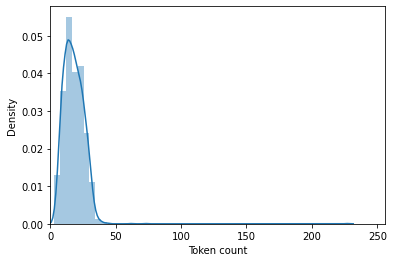

In [41]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [42]:
MAX_LEN = 128

In [43]:
class SarcasmDataset(Dataset):

  def __init__(self, tweets, targets, tokenizer, max_len):
    self.tweets = tweets
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.tweets)
  
  def __getitem__(self, item):
    tweet = str(self.tweets[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      tweet,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'tweet_text': tweet,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [44]:
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [45]:
print(device)

cuda:0


In [46]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.3, random_state=RANDOM_SEED)

In [47]:
df_train.shape, df_val.shape, df_test.shape

((3052, 3), (534, 3), (230, 3))

In [48]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = SarcasmDataset(
    tweets=df.Tweet.to_numpy(),
    targets=df.Label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [49]:
BATCH_SIZE = 32

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [50]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [51]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])


In [52]:
bert_model_1 = DistilBertModel.from_pretrained(PRE_TRAINED_MODEL_NAME,output_hidden_states=True)
bert_model_1.resize_token_embeddings(len(tokenizer))

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Embedding(30685, 768)

In [53]:
last_hidden_state, pooled_output = bert_model_1(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask'],
  return_dict = False
)

In [54]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [55]:
bert_model_1.config.hidden_size

768

In [56]:
pooled_output.shape

AttributeError: ignored

In [57]:
class SarcasmClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SarcasmClassifier, self).__init__()
    self.l1 = bert_model_1
    self.pre_classifier = torch.nn.Linear(768, 768)
    self.dropout = torch.nn.Dropout(0.3)
    self.classifier = torch.nn.Linear(768, 2)
  def forward(self, input_ids, attention_mask):
    output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
    hidden_state = output_1[0]
    pooler = hidden_state[:, 0]
    pooler = self.pre_classifier(pooler)
    pooler = torch.nn.ReLU()(pooler)
    pooler = self.dropout(pooler)
    output = self.classifier(pooler)
    return output
    

In [58]:
class_names=['1', '0']

In [59]:
len(class_names)

2

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

NameError: ignored

In [60]:
model = SarcasmClassifier(len(class_names))
model.to(device)

SarcasmClassifier(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30685, 768)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_features=768, out_

In [61]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 128])
torch.Size([32, 128])


In [62]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.4907, 0.5093],
        [0.4763, 0.5237],
        [0.4918, 0.5082],
        [0.5263, 0.4737],
        [0.5142, 0.4858],
        [0.5256, 0.4744],
        [0.5418, 0.4582],
        [0.4956, 0.5044],
        [0.5061, 0.4939],
        [0.5340, 0.4660],
        [0.5131, 0.4869],
        [0.4946, 0.5054],
        [0.4903, 0.5097],
        [0.5113, 0.4887],
        [0.5048, 0.4952],
        [0.5408, 0.4592],
        [0.5397, 0.4603],
        [0.5225, 0.4775],
        [0.5183, 0.4817],
        [0.4848, 0.5152],
        [0.5118, 0.4882],
        [0.5292, 0.4708],
        [0.5252, 0.4748],
        [0.5032, 0.4968],
        [0.5278, 0.4722],
        [0.5248, 0.4752],
        [0.5140, 0.4860],
        [0.4306, 0.5694],
        [0.5158, 0.4842],
        [0.5042, 0.4958],
        [0.5463, 0.4537],
        [0.4806, 0.5194]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [63]:
EPOCHS = 5

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
                                {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay':0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=2.7e-5, eps= 1e-8)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
#EPOCHS = 4

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5, eps= 1e-8)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [64]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [65]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [66]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_semeval_distilbert_run2.bin')
    best_accuracy = val_acc

Epoch 1/5
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.6700206268578768 accuracy 0.5773263433813892


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.6319024562835693 accuracy 0.6367041198501873

Epoch 2/5
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.5444408707941572 accuracy 0.7264089121887287


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.6304372496464673 accuracy 0.6629213483146067

Epoch 3/5
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.4028433876422544 accuracy 0.8292922673656619


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.6850019518066855 accuracy 0.6704119850187266

Epoch 4/5
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.2950843176028381 accuracy 0.8810615989515073


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.7745270062895382 accuracy 0.6647940074906367

Epoch 5/5
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.21638433348077038 accuracy 0.9252948885976409


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.7637376802809098 accuracy 0.6779026217228464

CPU times: user 1min 41s, sys: 3.41 s, total: 1min 45s
Wall time: 1min 45s


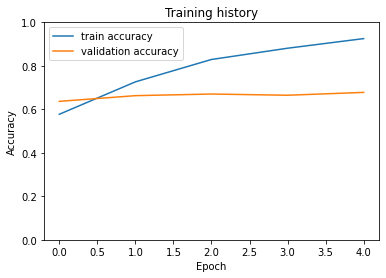

In [67]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

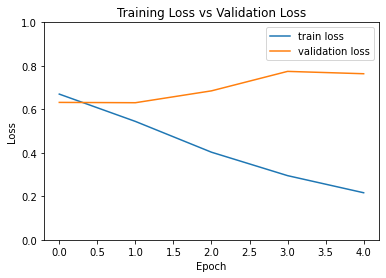

In [68]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [69]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  tweet_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["tweet_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      tweet_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return tweet_texts, predictions, prediction_probs, real_values

In [70]:
y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

In [72]:
print(classification_report(y_test, y_pred,target_names=class_names))

              precision    recall  f1-score   support

           1       0.66      0.66      0.66       118
           0       0.64      0.63      0.64       112

    accuracy                           0.65       230
   macro avg       0.65      0.65      0.65       230
weighted avg       0.65      0.65      0.65       230



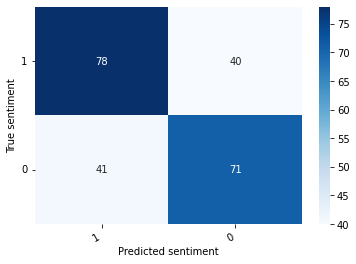

In [73]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [74]:
idx = 2

tweet_text = y_tweet_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [75]:
print("\n".join(wrap(tweet_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

why is paper so sharp someone should put a ban on paper
liberalmentality

True sentiment: 0


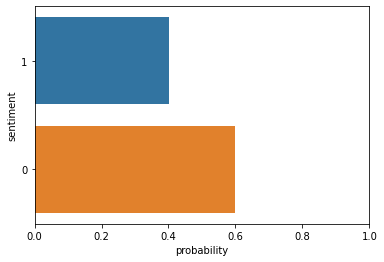

In [76]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [77]:
review_text = "Oh thank GOD our entire office email system is down... the day of a big event. Santa you know JUST what to get me for xmas"

In [78]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [79]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Tweet text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Tweet text: Oh thank GOD our entire office email system is down... the day of a big event. Santa you know JUST what to get me for xmas
Sentiment  : 0
